# Run model module GCP

In [10]:
import math
import os

def convert_conv_layer_property_lists_to_string(property_list, prop_list_len):
    """Convert conv layer property list to string.

    Args:
        property_list: list, nested list of blocks of a conv layer property.
        prop_list_len: int, length of list to process.

    Returns:
        Doubly delimited string of conv layer property values.
    """
    return (";").join(
        [
            (",").join([str(val) for val in block])
            for block in property_list[0:prop_list_len]
        ]
    )
    

# Import os environment variables for file hyperparameters.
os.environ["TRAIN_FILE_PATTERN"] = "gs://machine-learning-1234-bucket/gan/pgan/data/train*.tfrecord"
os.environ["EVAL_FILE_PATTERN"] = "gs://machine-learning-1234-bucket/gan/pgan/data/test*.tfrecord"
os.environ["OUTPUT_DIR"] = "gs://machine-learning-1234-bucket/gan/pgan/trained_model"

# Import os environment variables for train hyperparameters.
os.environ["TRAIN_BATCH_SIZE"] = str(16)
os.environ["TRAIN_STEPS"] = str(100000)

# Import os environment variables for eval hyperparameters.
os.environ["EVAL_BATCH_SIZE"] = str(1)
os.environ["EVAL_STEPS"] = str(1)
os.environ["START_DELAY_SECS"] = str(600)
os.environ["THROTTLE_SECS"] = str(600)

# Import os environment variables for serving hyperparameters.
os.environ["EXPORTS_TO_KEEP"] = str(144)
os.environ["PREDICT_ALL_RESOLUTIONS"] = "True"

# Import os environment variables for image hyperparameters.
os.environ["HEIGHT"] = str(32)
os.environ["WIDTH"] = str(32)
os.environ["DEPTH"] = str(3)

# Import os environment variables for shared hyperparameters.
os.environ["NUM_STEPS_UNTIL_GROWTH"] = str(10)

# Full lists for full 1024x1024 network growth.
full_conv_num_filters = [[512, 512], [512, 512], [512, 512], [512, 512], [256, 256], [128, 128], [64, 64], [32, 32], [16, 16]]
full_conv_kernel_sizes = [[4, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
full_conv_strides = [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]

# Set final image size as a multiple of 2, starting at 4.
image_size = 1024
os.environ["IMAGE_SIZE"] = str(image_size)
prop_list_len = max(
    min(int(math.log(image_size, 2) - 1), len(full_conv_num_filters)), 1
)

# Get slices of lists.
conv_num_filters = convert_conv_layer_property_lists_to_string(
    full_conv_num_filters, prop_list_len
)
print("conv_num_filters = {}".format(conv_num_filters))
conv_kernel_sizes = convert_conv_layer_property_lists_to_string(
    full_conv_kernel_sizes, prop_list_len
)
print("conv_kernel_sizes = {}".format(conv_kernel_sizes))
conv_strides = convert_conv_layer_property_lists_to_string(
    full_conv_strides, prop_list_len
)
print("conv_strides = {}".format(conv_strides))

os.environ["CONV_NUM_FILTERS"] = conv_num_filters
os.environ["CONV_KERNEL_SIZES"] = conv_kernel_sizes
os.environ["CONV_STRIDES"] = conv_strides

# Import os environment variables for generator hyperparameters.
os.environ["LATENT_SIZE"] = str(512)
os.environ["NORMALIZE_LATENT"] = "True"
os.environ["USE_PIXEL_NORM"] = "True"
os.environ["PIXEL_NORM_EPSILON"] = str(1e-8)
os.environ["GENERATOR_PROJECTION_DIMS"] = "4,4,512"
os.environ["GENERATOR_L1_REGULARIZATION_SCALE"] = str(0.01)
os.environ["GENERATOR_L2_REGULARIZATION_SCALE"] = str(0.01)
os.environ["GENERATOR_OPTIMIZER"] = "Adam"
os.environ["GENERATOR_LEARNING_RATE"] = str(0.0001)
os.environ["GENERATOR_CLIP_GRADIENTS"] = str(5.0)
os.environ["GENERATOR_TRAIN_STEPS"] = str(1)

# Import os environment variables for discriminator hyperparameters.
os.environ["USE_MINIBATCH_STDDEV"] = "True"
os.environ["MINIBATCH_STDDEV_GROUP_SIZE"] = str(4)
os.environ["MINIBATCH_STDDEV_AVERAGING"] = "True"
os.environ["DISCRIMINATOR_L1_REGULARIZATION_SCALE"] = str(0.01)
os.environ["DISCRIMINATOR_L2_REGULARIZATION_SCALE"] = str(0.01)
os.environ["DISCRIMINATOR_OPTIMIZER"] = "Adam"
os.environ["DISCRIMINATOR_LEARNING_RATE"] = str(0.0001)
os.environ["DISCRIMINATOR_CLIP_GRADIENTS"] = str(5.0)
os.environ["DISCRIMINATOR_GRADIENT_PENALTY_COEFFICIENT"] = str(10.0)
os.environ["EPSILON_DRIFT"] = str(0.001)
os.environ["DISCRIMINATOR_TRAIN_STEPS"] = str(1)


conv_num_filters = 512,512;512,512;512,512;512,512;256,256;128,128;64,64;32,32;16,16
conv_kernel_sizes = 4,3;3,3;3,3;3,3;3,3;3,3;3,3;3,3;3,3
conv_strides = 1,1;1,1;1,1;1,1;1,1;1,1;1,1;1,1;1,1


In [7]:
PROJECT = "machine-learning-1234"
BUCKET = "machine-learning-1234-bucket"
REGION = "us-central1"

# Import os environment variables
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] =  BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "1.15"
os.environ["PYTHON_VERSION"] = "3.5"

## Train pGAN model

In [8]:
%%bash
JOBNAME=pgan_${IMAGE_SIZE}x${IMAGE_SIZE}_$(date -u +%y%m%d_%H%M%S)
echo ${OUTPUT_DIR} ${REGION} ${JOBNAME}
gsutil -m rm -rf ${OUTPUT_DIR}
gcloud ai-platform jobs submit training ${JOBNAME} \
    --region=${REGION} \
    --module-name=trainer.task \
    --package-path=$PWD/pgan_module/trainer \
    --job-dir=${OUTPUT_DIR} \
    --staging-bucket=gs://${BUCKET} \
    --scale-tier=BASIC_TPU \
    --runtime-version=${TFVERSION} \
    --python-version=${PYTHON_VERSION} \
    -- \
    --train_file_pattern=${TRAIN_FILE_PATTERN} \
    --eval_file_pattern=${EVAL_FILE_PATTERN} \
    --output_dir=${OUTPUT_DIR} \
    --job-dir=./tmp \
    \
    --train_batch_size=${TRAIN_BATCH_SIZE} \
    --train_steps=${TRAIN_STEPS} \
    \
    --eval_batch_size=${EVAL_BATCH_SIZE} \
    --eval_steps=${EVAL_STEPS} \
    --start_delay_secs=${START_DELAY_SECS} \
    --throttle_secs=${THROTTLE_SECS} \
    \
    --exports_to_keep=${EXPORTS_TO_KEEP} \
    --predict_all_resolutions=${PREDICT_ALL_RESOLUTIONS} \
    \
    --height=${HEIGHT} \
    --width=${WIDTH} \
    --depth=${DEPTH} \
    \
    --num_steps_until_growth=${NUM_STEPS_UNTIL_GROWTH} \
    --conv_num_filters=${CONV_NUM_FILTERS} \
    --conv_kernel_sizes=${CONV_KERNEL_SIZES} \
    --conv_strides=${CONV_STRIDES} \
    \
    --latent_size=${LATENT_SIZE} \
    --normalize_latent=${NORMALIZE_LATENT} \
    --use_pixel_norm=${USE_PIXEL_NORM} \
    --pixel_norm_epsilon=${PIXEL_NORM_EPSILON} \
    --generator_projection_dims=${GENERATOR_PROJECTION_DIMS} \
    --generator_l1_regularization_scale=${GENERATOR_L1_REGULARIZATION_SCALE} \
    --generator_l2_regularization_scale=${GENERATOR_L2_REGULARIZATION_SCALE} \
    --generator_optimizer=${GENERATOR_OPTIMIZER} \
    --generator_learning_rate=${GENERATOR_LEARNING_RATE} \
    --generator_clip_gradients=${GENERATOR_CLIP_GRADIENTS} \
    --generator_train_steps=${GENERATOR_TRAIN_STEPS} \
    \
    --use_minibatch_stddev=${USE_MINIBATCH_STDDEV} \
    --minibatch_stddev_group_size=${MINIBATCH_STDDEV_GROUP_SIZE} \
    --minibatch_stddev_averaging=${MINIBATCH_STDDEV_AVERAGING} \
    --discriminator_l1_regularization_scale=${DISCRIMINATOR_L1_REGULARIZATION_SCALE} \
    --discriminator_l2_regularization_scale=${DISCRIMINATOR_L2_REGULARIZATION_SCALE} \
    --discriminator_optimizer=${DISCRIMINATOR_OPTIMIZER} \
    --discriminator_learning_rate=${DISCRIMINATOR_LEARNING_RATE} \
    --discriminator_clip_gradients=${DISCRIMINATOR_CLIP_GRADIENTS} \
    --discriminator_gradient_penalty_coefficient=${DISCRIMINATOR_GRADIENT_PENALTY_COEFFICIENT} \
    --epsilon_drift=${EPSILON_DRIFT} \
    --discriminator_train_steps=${DISCRIMINATOR_TRAIN_STEPS}

gs://machine-learning-1234-bucket/gan/pgan/trained_model us-central1 pgan_8x8_200606_075016
jobId: pgan_8x8_200606_075016
state: QUEUED


Removing gs://machine-learning-1234-bucket/gan/pgan/trained_model/#1591422484300972...
Removing gs://machine-learning-1234-bucket/gan/pgan/trained_model/checkpoint#1591422895227531...
Removing gs://machine-learning-1234-bucket/gan/pgan/trained_model/eval/#1591422934615173...
Removing gs://machine-learning-1234-bucket/gan/pgan/trained_model/eval/events.out.tfevents.1591422934.tf-1-15#1591422936651135...
Removing gs://machine-learning-1234-bucket/gan/pgan/trained_model/events.out.tfevents.1591422486.tf-1-15#1591422898710352...
Removing gs://machine-learning-1234-bucket/gan/pgan/trained_model/export/#1591422937865982...
Removing gs://machine-learning-1234-bucket/gan/pgan/trained_model/export/exporter/#1591422938187720...
Removing gs://machine-learning-1234-bucket/gan/pgan/trained_model/export/exporter/1591422936/#1591422952142281...
Removing gs://machine-learning-1234-bucket/gan/pgan/trained_model/export/exporter/1591422936/saved_model.pb#1591422952364535...
Removing gs://machine-learning

## Prediction

## 2.5 hours of training

In [31]:
!gsutil ls ${OUTPUT_DIR}/export/exporter | tail -1

gs://machine-learning-1234-bucket/gan/pgan/gcp_trained_model_tpu/export/exporter/1591285051/


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

predict_fn = tf.contrib.predictor.from_saved_model(
    "gs://machine-learning-1234-bucket/gan/pgan/gcp_trained_model_tpu/export/exporter/1591285051/"
)
predictions = predict_fn(
    {
        "Z": np.random.normal(size=(500, 512))
    }
)

INFO:tensorflow:Restoring parameters from gs://machine-learning-1234-bucket/gan/pgan/gcp_trained_model_tpu/export/exporter/1591285051/variables/variables


### Raw

In [26]:
generated_images = predictions["generated_images"]
print(generated_images.shape)

(500, 4, 4, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


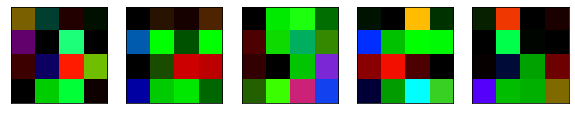

In [27]:
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(generated_images[i], cmap=plt.cm.binary)
plt.show()

### Rescaled

Convert image back to the original scale.

In [28]:
generated_images_scaled = np.clip(
    a=((predictions["generated_images"] + 1.0) * (255. / 2)).astype(np.int32),
    a_min=0,
    a_max=255
)

In [29]:
print(generated_images_scaled.shape)

(500, 4, 4, 3)


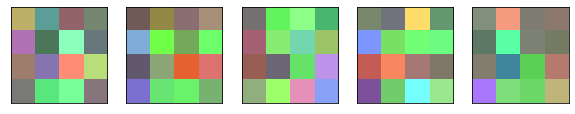

In [30]:
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(generated_images_scaled[i], cmap=plt.cm.binary)
plt.show()

## 6 hours of training

In [33]:
!gsutil ls ${OUTPUT_DIR}/export/exporter | tail -1

gs://machine-learning-1234-bucket/gan/pgan/gcp_trained_model_tpu/export/exporter/
gs://machine-learning-1234-bucket/gan/pgan/gcp_trained_model_tpu/export/exporter/1591285051/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

predict_fn = tf.contrib.predictor.from_saved_model(
    "gs://machine-learning-1234-bucket/gan/pgan/gcp_trained_model_tpu/export/exporter/1591285051/"
)
predictions = predict_fn(
    {
        "Z": np.random.normal(size=(500, 512))
    }
)

In [1]:
!ls ../..

ano_gan				data   vanilla_gan
create_tfrecords_cifar10.ipynb	dcgan  wgan
create_tfrecords_cifar10.py	pgan   wgan_gp


In [2]:
!mkdir ../../f_anogan_simultaneous_encoder

In [3]:
!mkdir ../../f_anogan_simultaneous_encoder/tf_f_anogan_simultaneous_encoder

In [4]:
!ls

data					 tf_pgan_loop_module.ipynb
demand_forecasting_run_module_gcp.ipynb  tf_pgan_loop_run_module_local.ipynb
local_trained_model			 tf_pgan_module.ipynb
pgan_loop_module			 tf_pgan_run_module_gcp.ipynb
pgan_module				 tf_pgan_run_module_local.ipynb
tf_pgan_local.ipynb			 trained_model


In [2]:
%%bash
cp tf_pgan_local.ipynb ../../f_anogan_simultaneous_encoder/tf_f_anogan_simultaneous_encoder
cp tf_pgan_module.ipynb ../../f_anogan_simultaneous_encoder/tf_f_anogan_simultaneous_encoder
cp tf_pgan_run_module_local.ipynb ../../f_anogan_simultaneous_encoder/tf_f_anogan_simultaneous_encoder
cp -r pgan_module ../../f_anogan_simultaneous_encoder/tf_f_anogan_simultaneous_encoder